# Clustering Notebook

In this notebook we will explore clustering methods on the survey answer data

In [2]:
import pandas as pd
data = pd.read_csv('../data/cleaned_data_v2.csv')

Filter the data

In [3]:
# Load scoring table
scoring = pd.read_excel('../scoring/scoring.xlsx')
survey_answer_cols = scoring['id'].tolist()
clustering_data = data[survey_answer_cols]

Scale the data

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_scaled = scaler.fit_transform(clustering_data)  # Standardize to mean=0, std=1


K-means

In [1]:
from sklearn.cluster import MiniBatchKMeans

mb_kmeans = MiniBatchKMeans(n_clusters=6, random_state=42, batch_size=1000)
mb_clusters = mb_kmeans.fit_predict(data_scaled)
data['mb_kmeans_cluster'] = mb_clusters


KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

print("Davies-Bouldin Score:", davies_bouldin_score(data_scaled, data['mb_kmeans_cluster']))
print("Calinski-Harabasz Score:", calinski_harabasz_score(data_scaled, data['mb_kmeans_cluster']))

Davies-Bouldin Score: 2.6497384169081406
Calinski-Harabasz Score: 35560.97423203533


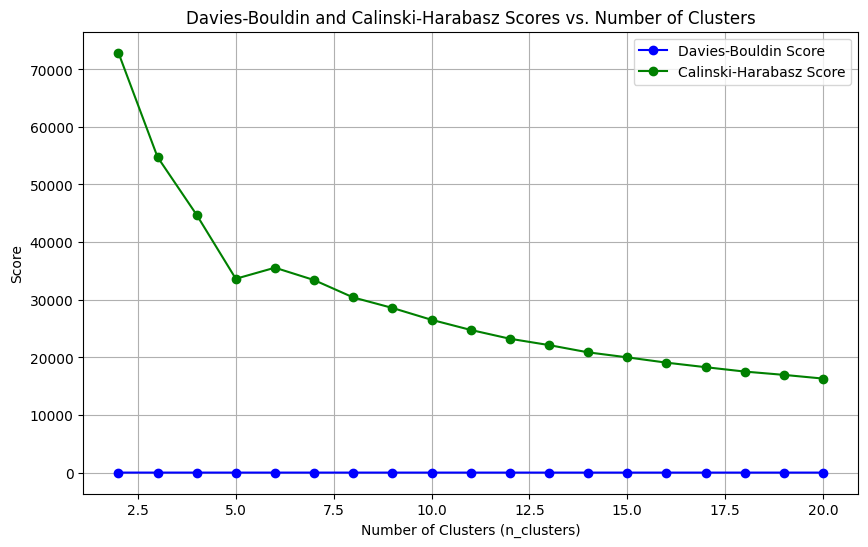

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

# Define a range of n_clusters to test
cluster_range = range(2, 21)  # Try cluster numbers from 2 to 20

# Initialize lists to store the scores for each n_clusters
dbi_scores = []
ch_scores = []

# Loop through the range of n_clusters
for n_clusters in cluster_range:
    mb_kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, batch_size=1000)
    mb_clusters = mb_kmeans.fit_predict(data_scaled)
    
    # Calculate Davies-Bouldin and Calinski-Harabasz scores
    dbi = davies_bouldin_score(data_scaled, mb_clusters)
    ch = calinski_harabasz_score(data_scaled, mb_clusters)
    
    # Append the scores to the respective lists
    dbi_scores.append(dbi)
    ch_scores.append(ch)



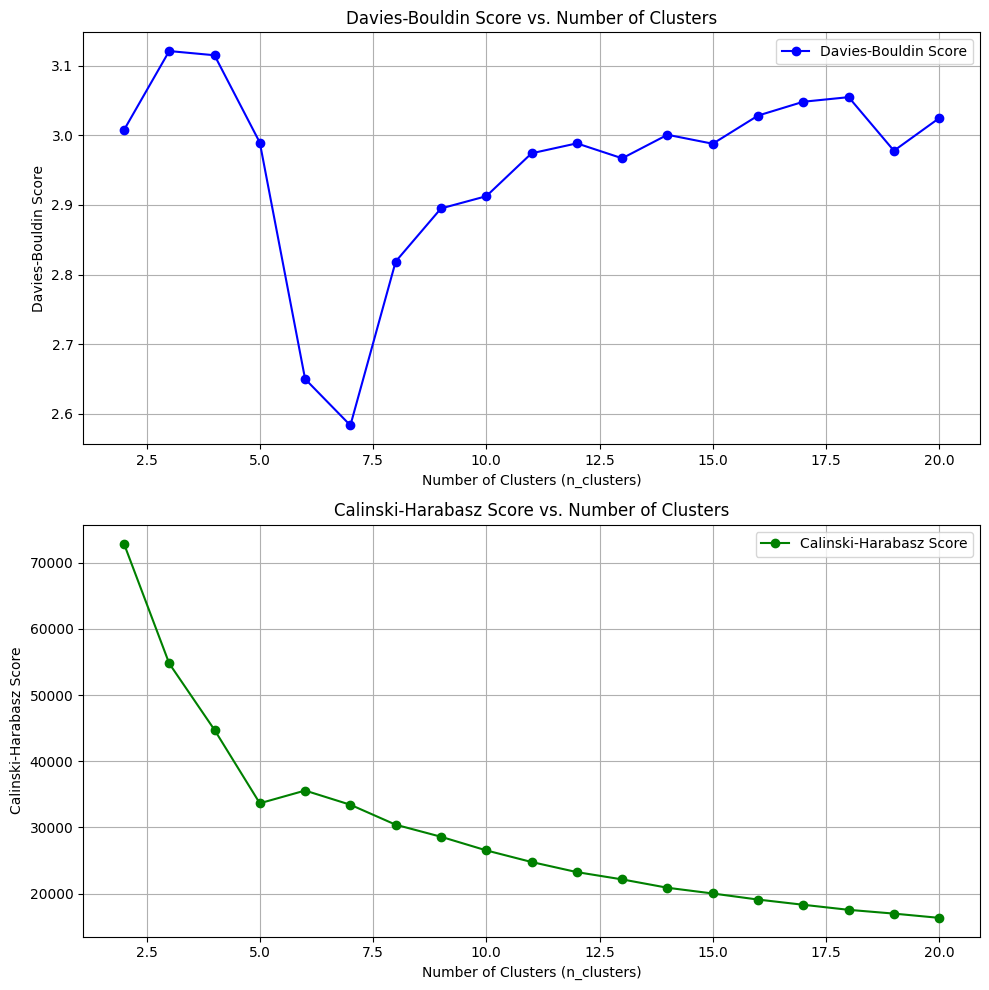

In [ ]:
# Create 2x1 grid of subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Plot Davies-Bouldin Score on the first subplot (ax1)
ax1.plot(cluster_range, dbi_scores, label='Davies-Bouldin Score', color='blue', marker='o')
ax1.set_xlabel('Number of Clusters (n_clusters)')
ax1.set_ylabel('Davies-Bouldin Score')
ax1.set_title('Davies-Bouldin Score vs. Number of Clusters')
ax1.grid(True)
ax1.legend()

# Plot Calinski-Harabasz Score on the second subplot (ax2)
ax2.plot(cluster_range, ch_scores, label='Calinski-Harabasz Score', color='green', marker='o')
ax2.set_xlabel('Number of Clusters (n_clusters)')
ax2.set_ylabel('Calinski-Harabasz Score')
ax2.set_title('Calinski-Harabasz Score vs. Number of Clusters')
ax2.grid(True)
ax2.legend()

# Adjust layout for better spacing
plt.tight_layout()

# Show plot
plt.show()

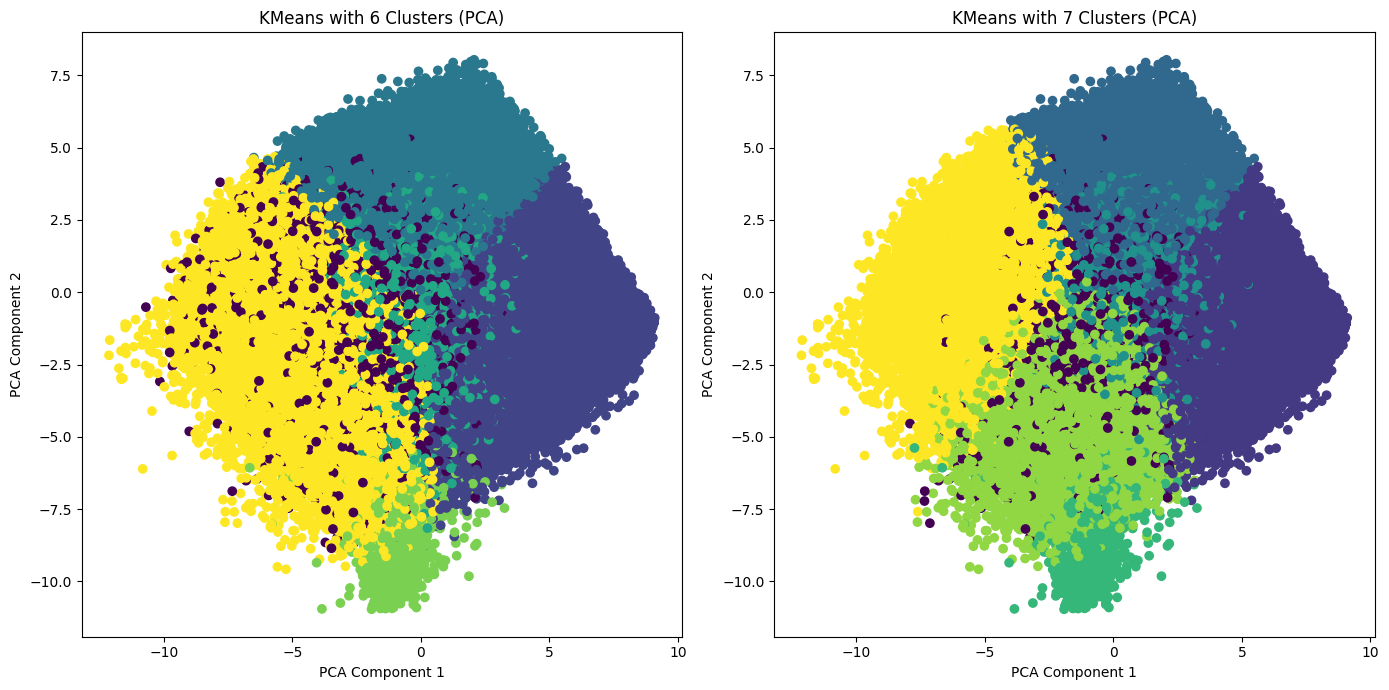

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Fit KMeans with 6 and 7 clusters
kmeans_6 = MiniBatchKMeans(n_clusters=6, random_state=42, batch_size=1000)
kmeans_7 = MiniBatchKMeans(n_clusters=7, random_state=42, batch_size=1000)

# Assign clusters
clusters_6 = kmeans_6.fit_predict(data_scaled)
clusters_7 = kmeans_7.fit_predict(data_scaled)

# Use PCA for dimensionality reduction (2D)
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

# Alternatively, you can use t-SNE (it might take longer, especially with a large dataset)
# tsne = TSNE(n_components=2, random_state=42)
# data_tsne = tsne.fit_transform(data_scaled)

# Create subplots to show the visualizations
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Plot for 6 clusters
axes[0].scatter(data_pca[:, 0], data_pca[:, 1], c=clusters_6, cmap='viridis', marker='o')
axes[0].set_title('KMeans with 6 Clusters (PCA)')
axes[0].set_xlabel('PCA Component 1')
axes[0].set_ylabel('PCA Component 2')

# Plot for 7 clusters
axes[1].scatter(data_pca[:, 0], data_pca[:, 1], c=clusters_7, cmap='viridis', marker='o')
axes[1].set_title('KMeans with 7 Clusters (PCA)')
axes[1].set_xlabel('PCA Component 1')
axes[1].set_ylabel('PCA Component 2')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


Other Clustering Methods

In [9]:
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN, AgglomerativeClustering, MeanShift
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
from tqdm import tqdm

# Subset the data (let's say we use 10% of the original data for faster testing)
subset_size = int(0.1 * len(data_scaled))  # 10% of the data
subset_data = data_scaled[np.random.choice(data_scaled.shape[0], subset_size, replace=False)]

# Define the clustering algorithms and their number of clusters
clustering_methods = {
    "Agglomerative Clustering": AgglomerativeClustering(n_clusters=6, linkage="single"),
    "Gaussian Mixture Model (GMM)": GaussianMixture(n_components=6, random_state=42),
    "DBSCAN": DBSCAN(eps=1.5, min_samples=10),
   
    #"Mean Shift": MeanShift()
}

# Initialize dictionaries to store the scores
db_scores = {}
ch_scores = {}

# Function to calculate scores for each model
def calculate_scores(method_name, model, data):
    if method_name == "DBSCAN":  # DBSCAN doesn't require a fixed number of clusters
        clusters = model.fit_predict(data)
    else:
        clusters = model.fit_predict(data)

    # Calculate DB and CH scores
    db_score = davies_bouldin_score(data, clusters)
    ch_score = calinski_harabasz_score(data, clusters)

    return (method_name, db_score, ch_score)

# Run the clustering methods sequentially and track progress with tqdm
for method_name, model in tqdm(clustering_methods.items(), desc="Clustering Methods", unit="method"):
    method_name, db_score, ch_score = calculate_scores(method_name, model, subset_data)
    
    # Store the results in the dictionaries
    db_scores[method_name] = db_score
    ch_scores[method_name] = ch_score

# Print the DB and CH scores for each method
print("Davies-Bouldin Scores:")
for method, score in db_scores.items():
    print(f"{method}: {score:.4f}")

print("\nCalinski-Harabasz Scores:")
for method, score in ch_scores.items():
    print(f"{method}: {score:.4f}")


Clustering Methods: 100%|██████████| 3/3 [03:36<00:00, 72.08s/method] 

Davies-Bouldin Scores:
Agglomerative Clustering: 0.4785
Gaussian Mixture Model (GMM): 8.5942
DBSCAN: 1.0321

Calinski-Harabasz Scores:
Agglomerative Clustering: 4.3667
Gaussian Mixture Model (GMM): 1134.0433
DBSCAN: 268.8381


Idea: once we have clusters, computer the average trait scores for each cluster